## Introduction

Parent and child Face Similarity prediction with SiameseNetwork

# Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x /content/drive/MyDrive/kinship.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/kinship.rar

Creating    kinship                                                   OK
Extracting  kinship/Kinship-Verification-master.rar                        0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50%  OK 
Extracting  kinship/مقالات 2.rar                                          50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68%  OK 
Extracting  kinship/مقاله ها.rar                                       

In [ ]:
!unrar x /content/kinship/Kinship-Verification-master.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/kinship/Kinship-Verification-master.rar

Creating    Kinship-Verification-master                               OK
Creating    Kinship-Verification-master/.ipynb_checkpoints            OK
Extracting  Kinship-Verification-master/.ipynb_checkpoints/NN_project-checkpoint.ipynb       0%  OK 
Extracting  Kinship-Verification-master/.ipynb_checkpoints/Untitled1-checkpoint.ipynb       0%  OK 
Extracting  Kinship-Verification-master/2-classifier-model                 0%  OK 
Extracting  Kinship-Verification-master/2-classifier-model-enhanced        1%  OK 
Extracting  Kinship-Verification-master/2_class_classifier.ipynb           1%  OK 
Extracting  Kinship-Verification-master/demo_video.webm                    4%  7% 10% 13% 16% 19% 22% 25% 28% 31% 34% 37% 40% 43% 46% 49% 50%  O

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_kinface_dataset(dataset_path, img_size=(64, 64)):
    """
    Load and preprocess the KinFace dataset with naming convention (_1 for parent, _2 for child).

    Parameters:
        dataset_path (str): Path to the KinFace dataset folder.
        img_size (tuple): Target size for resizing images (width, height).

    Returns:
        train_pairs, test_pairs, train_labels, test_labels
    """
    pairs = []
    labels = []

    # List all relationship folders (e.g., father-son, mother-daughter)
    relationships = os.listdir(dataset_path)

    for relationship in relationships:
        relationship_path = os.path.join(dataset_path, relationship)
        if not os.path.isdir(relationship_path):
            continue

        # Iterate over all files in the relationship folder
        images = sorted(os.listdir(relationship_path))  # Sorting ensures _1 and _2 pairing is correct

        for i in range(0, len(images), 2):
            if '_1' in images[i] and '_2' in images[i + 1]:
                # Read parent and child images
                parent_image = cv2.imread(os.path.join(relationship_path, images[i]))
                child_image = cv2.imread(os.path.join(relationship_path, images[i + 1]))

                # Resize and normalize images
                parent_image = cv2.resize(parent_image, img_size) / 255.0
                child_image = cv2.resize(child_image, img_size) / 255.0

                pairs.append([parent_image, child_image])
                labels.append(1)  # Label 1 for related pair

    # Generate negative pairs (unrelated pairs)
    unrelated_pairs = []
    unrelated_labels = []
    num_pairs = len(pairs)

    for _ in range(num_pairs):
        idx1, idx2 = np.random.choice(num_pairs, 2, replace=False)
        unrelated_pairs.append([pairs[idx1][0], pairs[idx2][1]])
        unrelated_labels.append(0)  # Label 0 for unrelated pair

    # Combine related and unrelated pairs
    all_pairs = np.array(pairs + unrelated_pairs)
    all_labels = np.array(labels + unrelated_labels)

    # Shuffle and split into train and test sets
    train_pairs, test_pairs, train_labels, test_labels = train_test_split(
        all_pairs, all_labels, test_size=0.2, random_state=42
    )

    return train_pairs, test_pairs, train_labels, test_labels

In [ ]:
dataset_path = "/content/Kinship-Verification-master/KinFaceW-II/images"
train_pairs, test_pairs, train_labels, test_labels = load_kinface_dataset(dataset_path, img_size=(64, 64))

#Image Preprocessing

In [ ]:
# Load and preprocess data (assume you have train_pairs, test_pairs, train_labels, test_labels)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


# Example preprocessing (add your own dataset loading logic here)
def preprocess_data(pairs, labels):
    """
    Prepares the data for the Siamese Network by splitting pairs into two separate inputs.

    Parameters:
        pairs (numpy.ndarray): Array of shape (num_samples, 2, height, width, channels).
        labels (numpy.ndarray): Array of labels (0 or 1) for each pair.

    Returns:
        tf.data.Dataset: TensorFlow dataset ready for training/testing.
    """


    # Split pairs into two separate inputs
    images_a = pairs[:, 0]  # First image in each pair
    images_b = pairs[:, 1]  # Second image in each pair

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(((images_a, images_b), labels))
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_data = preprocess_data(train_pairs, train_labels)
test_data = preprocess_data(test_pairs, test_labels)

# Model Designing and Implementation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.optimizers import Adam

# Define the feature extraction model
def create_base_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5)
    ])
    return model

# Define the Siamese Network
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    feature_a = base_model(input_a)
    feature_b = base_model(input_b)

    # Compute the absolute difference
    merged_features = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feature_a, feature_b])
    output = layers.Dense(1, activation='sigmoid')(merged_features)

    model = models.Model(inputs=[input_a, input_b], outputs=output)
    return model

# Input shape and model initialization
input_shape = (64, 64, 3)
siamese_model = create_siamese_network(input_shape)
siamese_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │      2,116,672 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,116,801 (8.07 MB)

 Trainable params: 2,116,801 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Traninning

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = siamese_model.fit(train_data, validation_data=test_data, epochs=50, callbacks=[early_stopping])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.5175 - loss: 0.7094 - val_accuracy: 0.5522 - val_loss: 0.6809
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5058 - loss: 0.7253 - val_accuracy: 0.5622 - val_loss: 0.6777
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4766 - loss: 0.7159 - val_accuracy: 0.6020 - val_loss: 0.6841
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5061 - loss: 0.6953 - val_accuracy: 0.5771 - val_loss: 0.6825
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5267 - loss: 0.6924 - val_accuracy: 0.6070 - val_loss: 0.6794
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5449 - loss: 0.6908 - val_accuracy: 0.5771 - val_loss: 0.6732
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5533 - loss: 0.6816 - val_accuracy: 0.5821 - val_loss: 0.6666
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5865 - loss: 0.6920 - val_accuracy: 0.5871 -

# Visualization

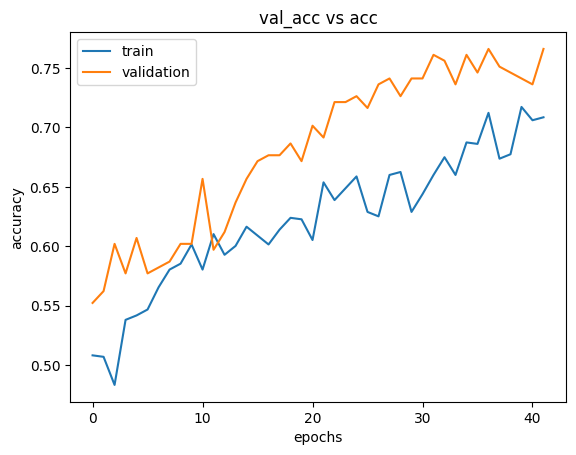

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('val_acc vs acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.show()

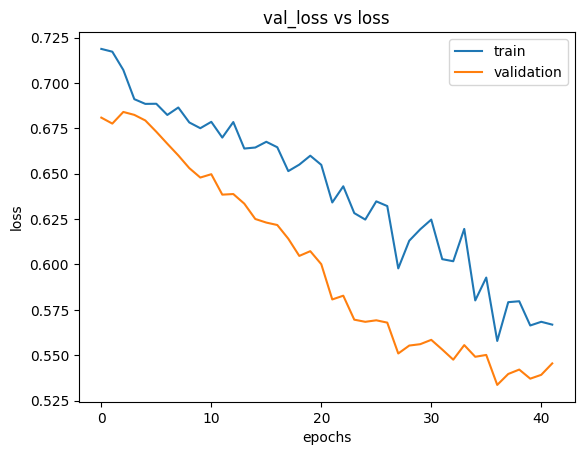

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('val_loss vs loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.show()

# Evaluation

In [ ]:
# Evaluate the model
test_loss, test_accuracy = siamese_model.evaluate(test_data)

print(f"Test Accuracy: {test_accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7652 - loss: 0.5320 
Test Accuracy: 0.77


# Prediction

In [ ]:
def show_plot(examples, n):
    for i in range(n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

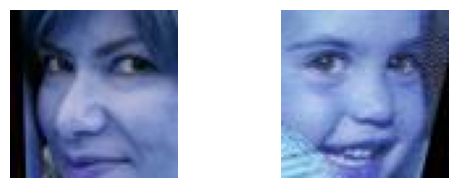

In [ ]:
show_plot(test_pairs[80], 2)

In [ ]:
prediction = siamese_model.predict(
    ([test_pairs[1][0][None, ...], test_pairs[2][1][None, ...]])
)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.54206616]]


In [ ]:
siamese_model.save('Face_similarity_ResNet50_30.h5')